# Omega implementation of Peroxisome Dynamics

In [1]:
## Load Packages
using Omega
using StatsBase
using Random
using Plots
using Distributions
using CSV
using DataFrames
using DataStructures

Internal error: encountered unexpected error in runtime:
rec_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\stackwalk.c:94
record_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:246
jl_throw at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:577
jl_bounds_error_ints at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\rtutils.c:187
getindex at .\array.jl:731
jfptr_getindex_2272.clone_1 at C:\Users\Devon Kohler\AppData\Local\Julia-1.0.5\lib\julia\sys.dll (unknown line)
jl_apply_generic at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\gf.c:2162
replace_code_newstyle! at .\compiler/ssair\legacy.jl:86

## Implement Gillespie Model

In [11]:
function simulation(rng, n, transitions)
    
    """
    Compute the hazard function given the current states.
    args:
        rng(): julia base random number generator, do not need to explicitly pass
        n(int): An index to the current step in prey and pred lists. Used to pull
                most recent values for calculations
    """
    
    ecology = Dict("X" => X_val_list[n])

    hazards = Dict(
        "H1" => theta["r1"],
        "H2" => ecology["X"]*theta["r2"],
        "H3" => ecology["X"]*theta["r3"]
        )

    vals = collect(values(hazards))
    sum_vals = sum(vals)
    new_t = t_list[n] + Omega.exponential(rng, 1/sum_vals)
    push!(t_list, new_t)
    
    prob_vals = vals/sum_vals
    hazard_result = Omega.categorical(rng, prob_vals)
    
    labels = ["H1", "H2", "H3"]
    transition = transitions[labels[hazard_result]]
    new_X = ecology["X"] + transition[1]

    # Enforce only positive integers
    new_x = max(1, new_X)
    push!(X_val_list, new_x)
    [new_x, new_t]
    
end

simulation (generic function with 1 method)

In [12]:
## Transition Matrix
Pre = [[0], [0], [0]]
Post = [[1], [1], [-1]]
transition_mat = Post - Pre
transitions = OrderedDict("H1" => transition_mat[1,],
                    "H2" => transition_mat[2,],
                    "H3" => transition_mat[3,])

OrderedDict{String,Array{Int64,1}} with 3 entries:
  "H1" => [1]
  "H2" => [1]
  "H3" => [-1]

In [13]:
# Initial Prey and Pred values
X_init = 240

# Rate Values
r1 = 2.51e-4
r2 = 10e-5
r3 = 10.5e-5

theta =  OrderedDict("r1" => r1,
         "r2" => r2,
         "r3" => r3)

OrderedDict{String,Float64} with 3 entries:
  "r1" => 0.000251
  "r2" => 0.0001
  "r3" => 0.000105

In [14]:
## Initialize lists and add starting rand vars
rand_var_list = Any[]
X_val_list = Any[]
t_list = Any[]
push!(X_val_list, X_init)
push!(t_list, 0)

## How many time periods to cycle over
N = 3500

## Create a prey/pred/hazard for each time period
for f in 2:N
    last = f - 1
    X_temp = ciid(simulation, last, transitions) # individual step
    push!(rand_var_list, X_temp)
end

## Convert lists to single tuple
random_var_tuple = Tuple(x for x in rand_var_list)#...)
print()

In [15]:
## Sample
Random.seed!(1234)
samples = rand(random_var_tuple, 1, alg = RejectionSample)
print()

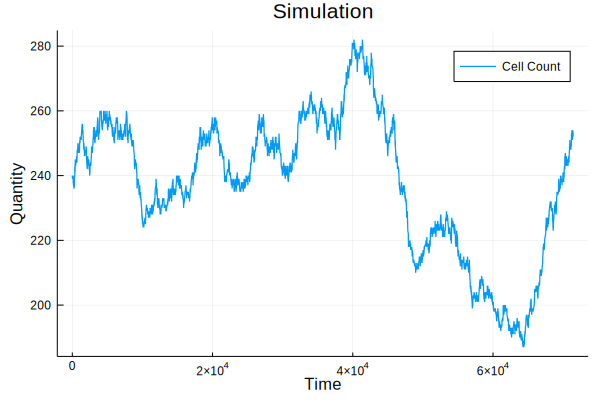

In [16]:
plot(t_list[1:N], X_val_list[1:N],
    title = "Simulation",
    xlabel = "Time",
    ylabel = "Quantity",
    label = "Cell Count",
    lw = 1.25)

## Load dataset

In [17]:
day1 = CSV.read("Experimental_Data/Data/Day1/all.dat", DataFrame)#, delim = ',')#, '\n')
day2 = CSV.read("Experimental_Data/Data/Day2/all.dat", DataFrame)
day3 = CSV.read("Experimental_Data/Data/Day3/all.dat", DataFrame)
print()

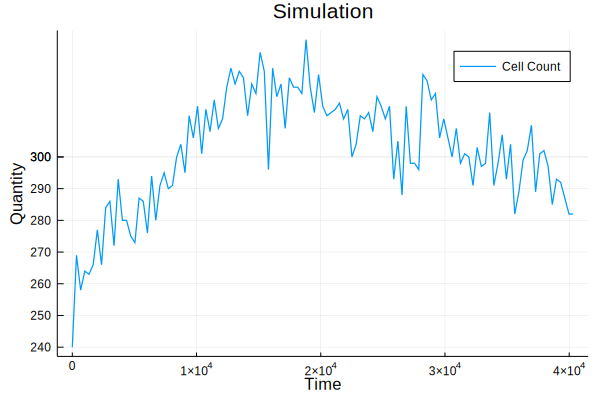

In [18]:
plot(day1[day1.Cell .== 1, :time],
    day1[day1.Cell .== 1, :count],
    title = "Simulation",
    xlabel = "Time",
    ylabel = "Quantity",
    label = "Cell Count",
    lw = 1.25)

### Steps to run causal inference on experimental data

1. Build Gillespie Simulation of Peroxisome Dynamics (Done)
    1. We assume the true relationship between cell count and time follows this simulation
2. Condition simulation on observed data - $P(Count_T | Data)$
    1. Use time points and counts as conditionals, allowing for some variablility between observed counts
3. Use Omega replace function to run counterfactuals on conditioned simulation
4. We have 43 traces we can do this process on

## Condition on Data

In [10]:
samples[1]

([239.0, 18.0716], [240.0, 35.0326], [239.0, 66.9835], [240.0, 71.5295], [239.0, 77.262], [240.0, 98.5151], [239.0, 99.905], [240.0, 121.032], [239.0, 127.563], [238.0, 128.747], [237.0, 190.038], [236.0, 249.72], [237.0, 285.114], [238.0, 287.148], [239.0, 289.936], [240.0, 344.262], [241.0, 349.995], [242.0, 350.944], [243.0, 377.353], [242.0, 389.264], [241.0, 390.215], [242.0, 399.364], [243.0, 408.713], [244.0, 411.896], [245.0, 422.222], [244.0, 443.526], [243.0, 449.535], [244.0, 456.445], [243.0, 475.596], [244.0, 503.568], [245.0, 524.097], [244.0, 538.847], [245.0, 550.119], [244.0, 554.517], [245.0, 559.413], [244.0, 563.951], [245.0, 598.881], [246.0, 618.811], [245.0, 648.26], [244.0, 649.061], [245.0, 660.284], [246.0, 678.842], [247.0, 692.468], [248.0, 707.102], [247.0, 709.385], [248.0, 729.106], [247.0, 731.453], [248.0, 767.228], [249.0, 776.793], [250.0, 803.666], [249.0, 810.345], [250.0, 834.195], [249.0, 846.616], [248.0, 850.787], [247.0, 910.249], [248.0, 922.6

Internal error: encountered unexpected error in runtime:
StackOverflowError()


In [124]:
day1[day1.Cell .== 1, : ]

,Column1,time,count,Cell
,Int64,Int64,Int64,Int64
1,1,0,240,1
2,2,336,269,1
3,3,672,258,1
4,4,1008,264,1
5,5,1344,263,1
6,6,1680,266,1
7,7,2016,277,1
8,8,2352,266,1
9,9,2688,284,1


In [14]:
5 < 10 & 12>5

true

In [19]:
## Initialize lists and add starting rand vars
rand_var_list = Any[]
X_val_list = Any[]
t_list = Any[]
push!(X_val_list, X_init)
push!(t_list, 0)

## How many time periods to cycle over
N = 3500

## Create a prey/pred/hazard for each time period
for f in 2:N
    last = f - 1
    if f == 25
        X_temp_ = ciid(simulation, last, transitions)
        X_temp_ = cond(X_temp_, X_temp_[2] > 330) # individual step
        X_temp_ = cond(X_temp_, X_temp_[1] > 260)
        X_temp = cond(X_temp_, X_temp_[1] < 275)
    else
        X_temp = ciid(simulation, last, transitions) # individual step
    end
    push!(rand_var_list, X_temp)
end

## Convert lists to single tuple
random_var_tuple = Tuple(x for x in rand_var_list)#...)
print()

In [ ]:
## Sample
Random.seed!(1234)
samples = rand(random_var_tuple, alg = RejectionSample)
print()

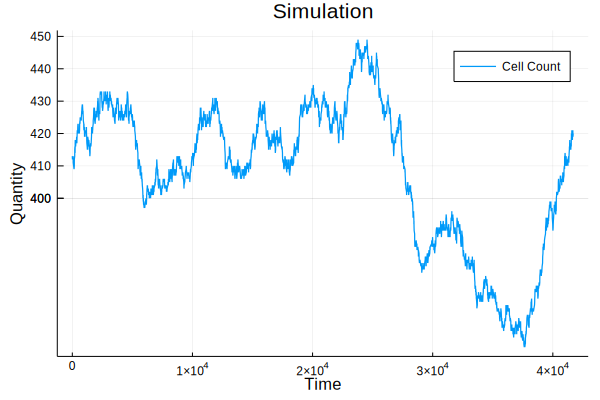

In [20]:
plot(t_list[1:N], X_val_list[1:N],
    title = "Simulation",
    xlabel = "Time",
    ylabel = "Quantity",
    label = "Cell Count",
    lw = 1.25)

In [131]:
function get_time_cond(output, cond_idx)
    return rand_var_list[cond_idx][2]
end
function get_x_cond(output, cond_idx)
    return rand_var_list[cond_idx][1]
end

#336	269

cond_idx = 36
cond_statement_time = ciid(get_time_cond, rand_var_list, cond_idx)
cond_statement_x = ciid(get_x_cond, rand_var_list, cond_idx)
print()